In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

In [10]:
print('''
Regression Discontinuity Design (RDD) is  method used to estimate causal effects by 
exploiting a cutoff or threshold in a continuous assignment variable (e.g., income, test scores) 
that determines treatment. In this , we will measure the of drinking age(21) on mortality


''')


Regression Discontinuity Design (RDD) is  method used to estimate causal effects by 
exploiting a cutoff or threshold in a continuous assignment variable (e.g., income, test scores) 
that determines treatment. In this , we will measure the of drinking age(21) on mortality





In [8]:
drinking = pd.read_csv('https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/drinking.csv')
drinking.head()[["agecell", "all", "mva", "suicide"]]
drinking["agecell"] -= 21


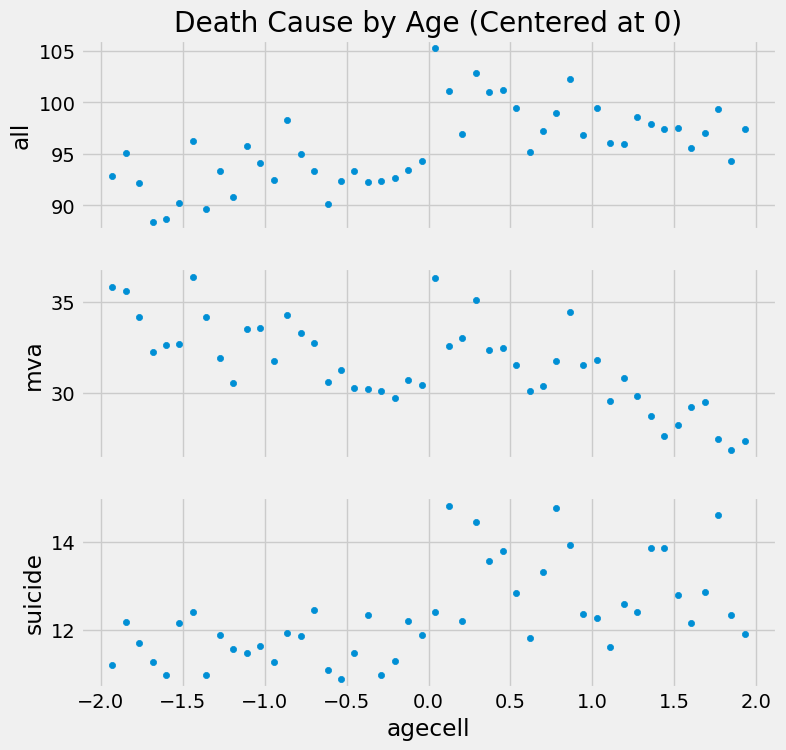

In [9]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);

In [11]:
#we create a variable for the threshold and measure the effects of the age on the mortailitaty
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


In [14]:
print('this tells us increases by 7.6 points with alcohol')

this tells us increases by 7.6 points with alcohol


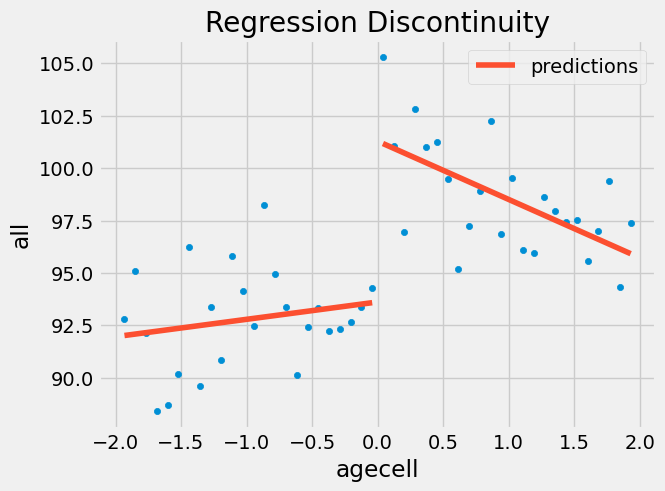

In [15]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

In [16]:
print("notice two diffferent models for two different datasets")

notice two diffferent models for two different datasets


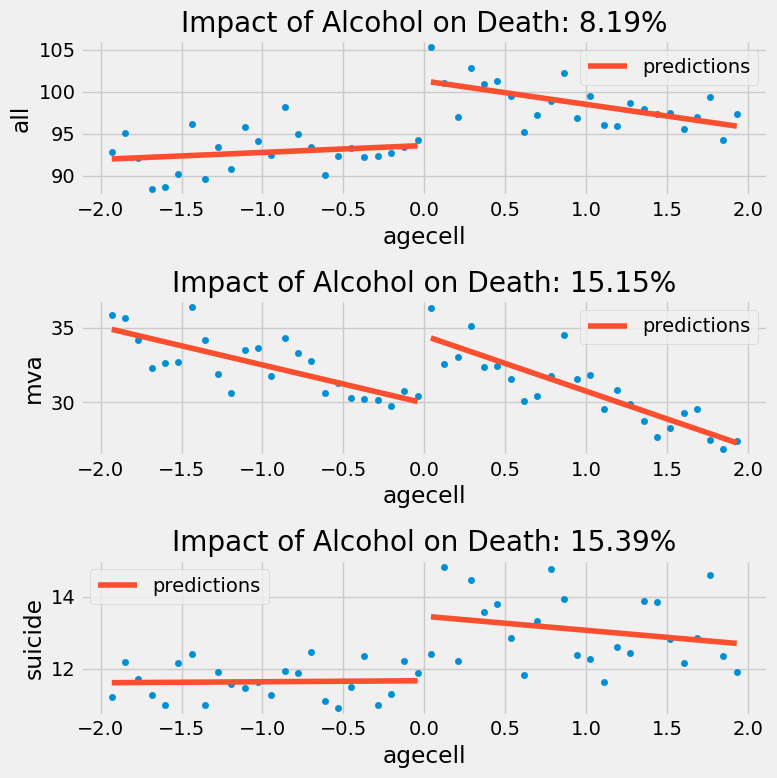

In [17]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

### Kernel Weighting

We want to value points closer to the threshold as those are more valuable". TO do so, we can apply kernel weighting

In [18]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

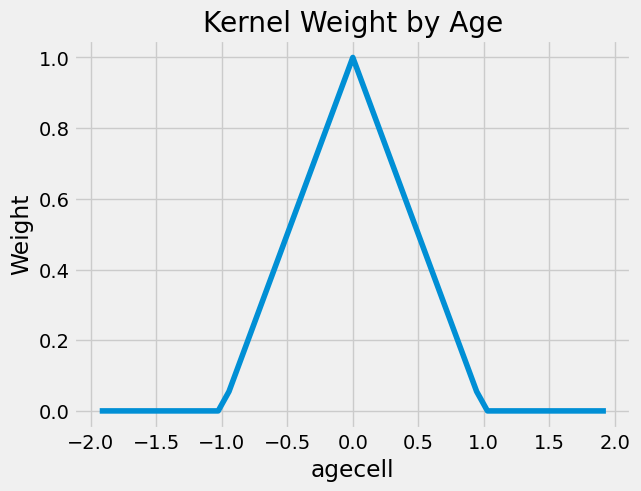

In [19]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

In [20]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


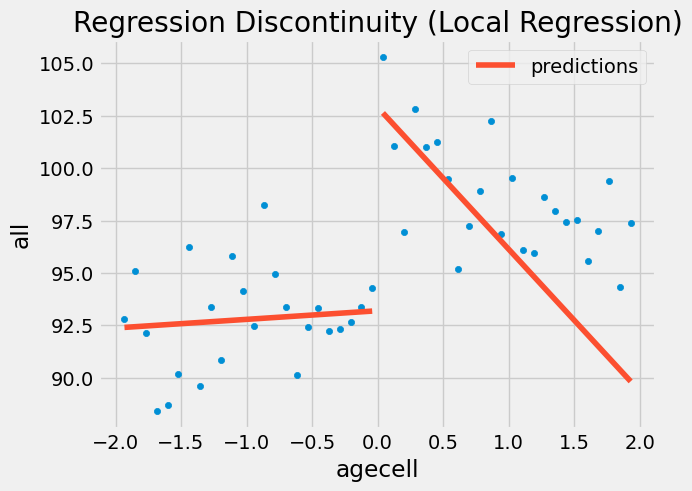

In [21]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

In [22]:
print("Affect gets stronger")


Affect gets stronger


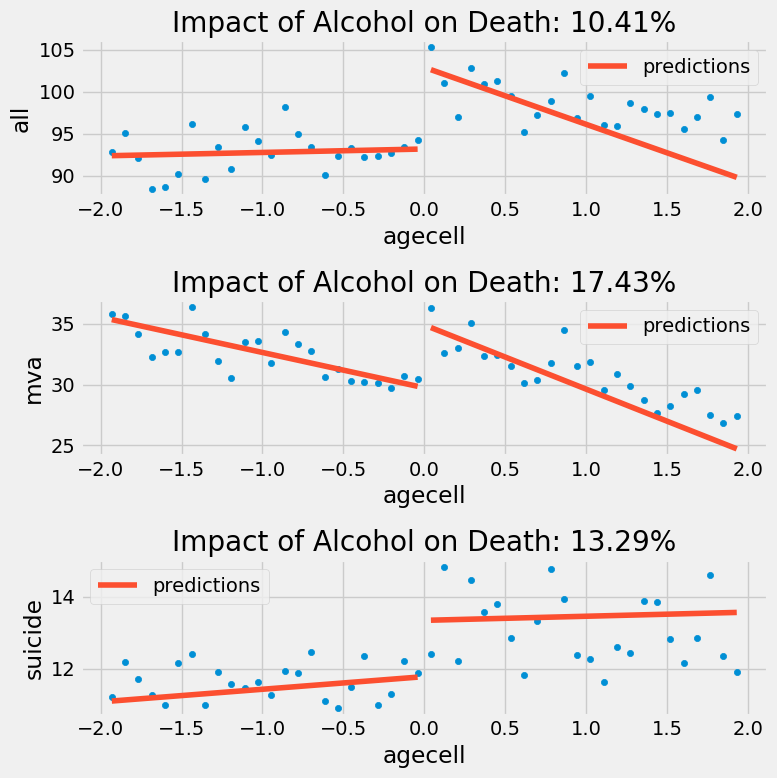

In [23]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

In [26]:
url='https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/sheepskin.csv'

sheepskin=pd.read_csv(url)
sheepskin.head()

,minscore,person_years,avgearnings,receivehsd,n
0,-30.0,24.0,11845.086,0.416667,12
1,-29.0,104.0,9205.679,0.387097,31
2,-28.0,146.0,8407.745,0.318182,44
3,-27.0,137.0,11114.087,0.377778,45
4,-26.0,227.0,10814.624,0.306667,75


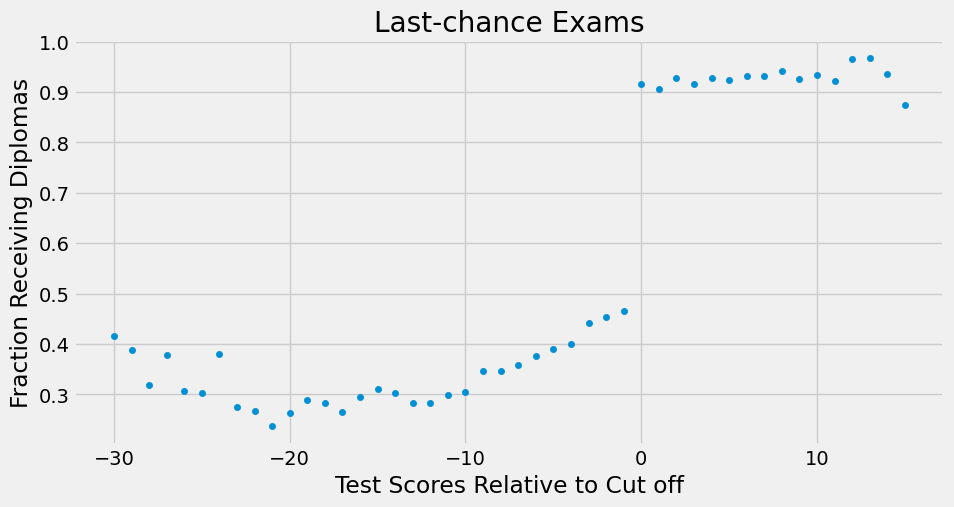

In [27]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

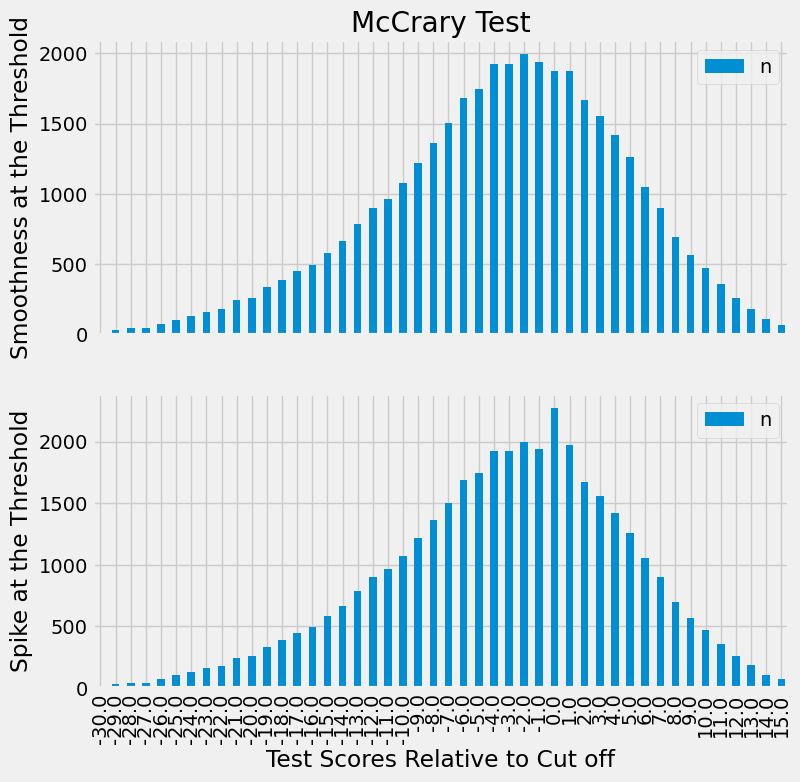

In [28]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

In [29]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


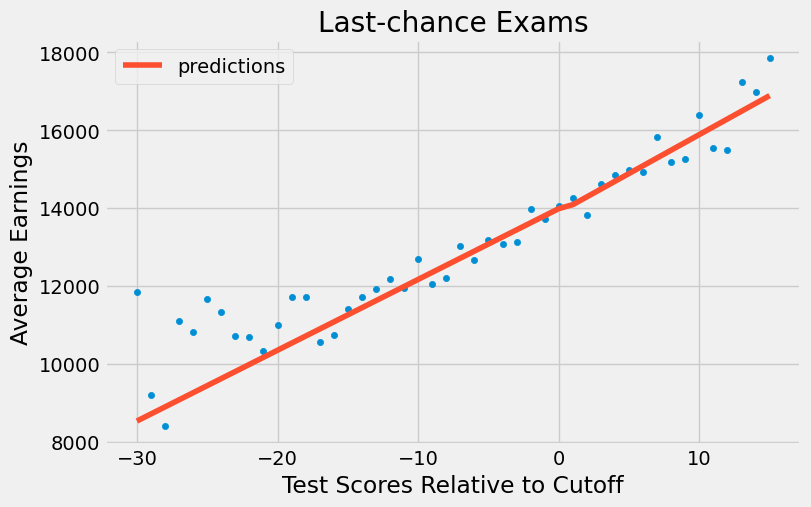

In [30]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

In [31]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]

In [32]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

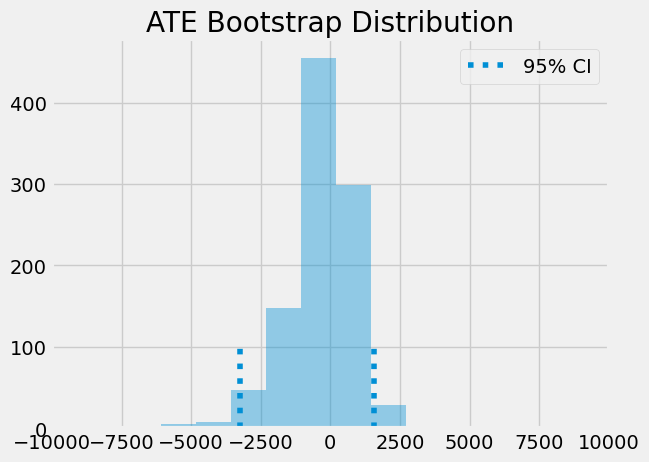

In [33]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend();

In [34]:
'''

Fuzzy Regression Discontinuity Design (Fuzzy RDD)
Fuzzy RDD is an extension of the Regression Discontinuity Design (RDD) used when treatment assignment around a cutoff is not perfectly deterministic. This means that crossing the cutoff influences the probability of treatment but does not guarantee it.


'''

'\n\nFuzzy Regression Discontinuity Design (Fuzzy RDD)\nFuzzy RDD is an extension of the Regression Discontinuity Design (RDD) used when treatment assignment around a cutoff is not perfectly deterministic. This means that crossing the cutoff influences the probability of treatment but does not guarantee it.\n\n\n'

1. Sharp RDD vs. Fuzzy RDD
Sharp RDD:
Treatment is fully determined by the cutoff.
Example: Students scoring ≥50 on a test automatically receive a scholarship, while those scoring <50 do not.
Fuzzy RDD:
The cutoff only influences the probability of receiving the treatment, but other factors may also determine it.
Example: In Texas, a state healthcare program may offer benefits to individuals earning below $30,000, but some people earning less might not enroll, and some earning more might still qualify through exceptions.